# Heat conduction of Composites

The aim of this lab is to investigate the heat conduction of composite materials. We will investigate the relation between effective heat conductivity and phase fraction of a "made-up" 2D composite.

## Computational domain

We have provided a set of three black-and-white images that will serve as our composites. These types of images can be obtained from X-Ray tomography data, microscopes (incl. SEM). Usually, they are grayscale and we have simply thresholded them.

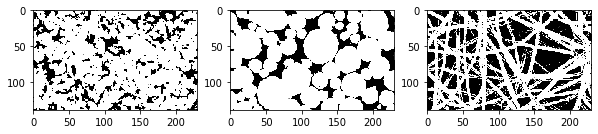

In [1]:
import matplotlib.pyplot as plt

composite1 = plt.imread('images/composite_1.tif')
composite2 = plt.imread('images/composite_2.tif')
composite3 = plt.imread('images/composite_3.tif')

fig=plt.figure(figsize=(10, 8));
fig.add_subplot(1, 3, 1);
plt.imshow(composite1);
fig.add_subplot(1, 3, 2);
plt.imshow(composite2);
fig.add_subplot(1, 3, 3);
plt.imshow(composite3);

These are TIFF images with a dynamic range from 0 to 255. The image size is 230x140. The first composite contains fairly small particles in a random arrangement. The second composite is similar but with much larger roughly spherical particles. The third composite is made of fibres.

## Phase fractions

Lets investigate the phase fractions of all three structures. We will do this by counting the number of white/black pixels relative to the total number of pixels.

In [2]:
import numpy as np;
phasefraction_1 = np.sum(composite1 > 120) / composite1.size;
phasefraction_2 = np.sum(composite2 > 120) / composite2.size;
phasefraction_3 = np.sum(composite3 > 120) / composite3.size;

print("Phase fraction Composite 1: {:6.3f}".format(phasefraction_1));
print("Phase fraction Composite 2: {:6.3f}".format(phasefraction_2));
print("Phase fraction Composite 3: {:6.3f}".format(phasefraction_3));

Phase fraction Composite 1:  0.793
Phase fraction Composite 2:  0.807
Phase fraction Composite 3:  0.567


In [3]:
phasefraction_3 = np.sum(composite3 < 120) / composite3.size
print("Phase fraction Composite 1: {:6.3f}".format(phasefraction_3));


Phase fraction Composite 1:  0.433


## Heat conductivity

The heat conductivity is taken to be

$$
\lambda(x,\alpha) = 1\,\text{for "white" phase}
$$
and

$$
\lambda(x,\alpha) = \alpha\,\text{for "black" phase}
$$

which is a form of relative heat conductivity.

In [181]:
def lmbda(x,alpha):
    '''
    Compute the relative heat conductivity taken the "white" phase (x>120) as
    the reference phase.
    
    Note: The misspelling is needed becasuse "lambda" is a 
          protected word Python.
    '''
    
    return (int(x<120)*alpha + int(x>=120)*1);

## Computational Problem

We will investigate the dynamic response of composite materials to an aprupt temperature change at time $t=0$. We will use normalised quantities to not be bothered with units etc. So the temperature change goes from $u=1$ to $u=0$ at time $t=0$ on the boundaries. The problem is described by this PDE

$$
\nabla (\lambda(x) \nabla u) = 0
$$

with the inhomogeneous heat conductivity $\lambda(x)$.

# FEM solution

## Mesh and Function space

We will operate on a triangular mesh with piecewise linear functions

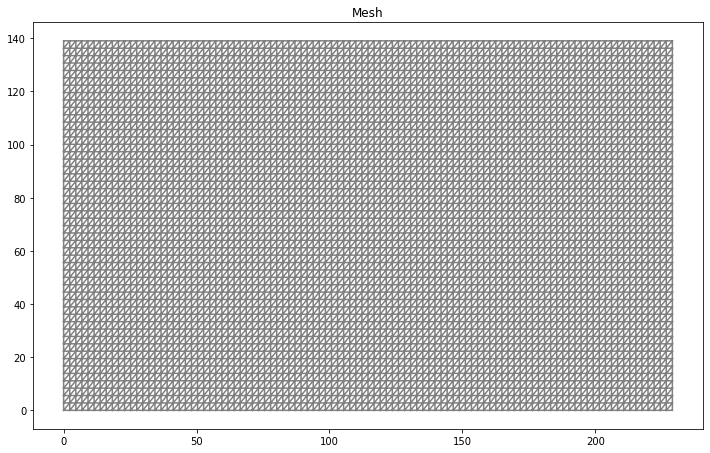

In [141]:
from dolfin import *;
import matplotlib.pyplot as plt;

mesh = RectangleMesh(Point(0.0,0.0),Point(229.,139.),100,50);
V = FunctionSpace(mesh, "Lagrange", 1);
plt.figure(figsize=(12,8));
plot(mesh, title="Mesh");

In [167]:
# Create classes for defining parts of the boundaries and the interior
# of the domain
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 229.0)

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 139.0)

class Obstacle(SubDomain):
    
    idx = lambda c,x : int(np.mean(c[int(np.floor(x[1])),int(np.floor(x[0])),:]) < 120);
    
    def inside(self, x, on_boundary):
        return idx(composite2,x)

# Initialize sub-domain instances
left = Left()
top = Top()
right = Right()
bottom = Bottom()
obstacle = Obstacle()

## Interpolating heat conductivities

Because the FEM mesh does not coincide with the image pixels, we need to interpolate lambda values. This is done by the following cell. It defines a function `psi` in the function space of the FEM solution and then fills function values according to the coordinates of its degrees of freedom (dof).

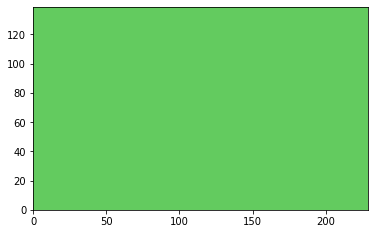

In [168]:
psi = Function(V);
idx = lambda c,x : lmbda(np.mean(c[int(np.floor(x[1])),int(np.floor(x[0])),:]),1);
psi.vector()[:] = [idx(composite2,x) for x in V.tabulate_dof_coordinates()]

plot(psi)

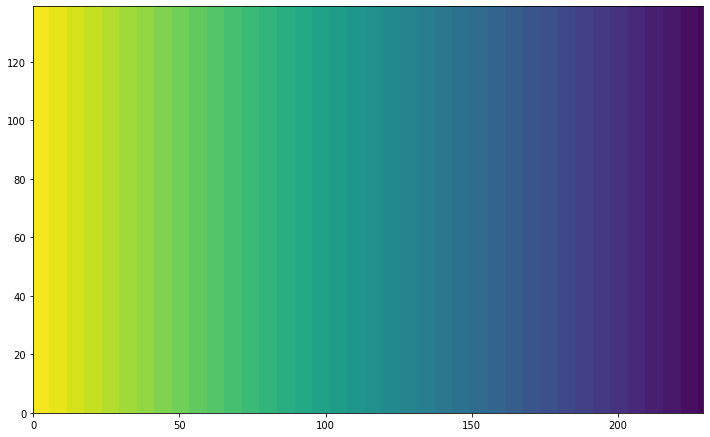

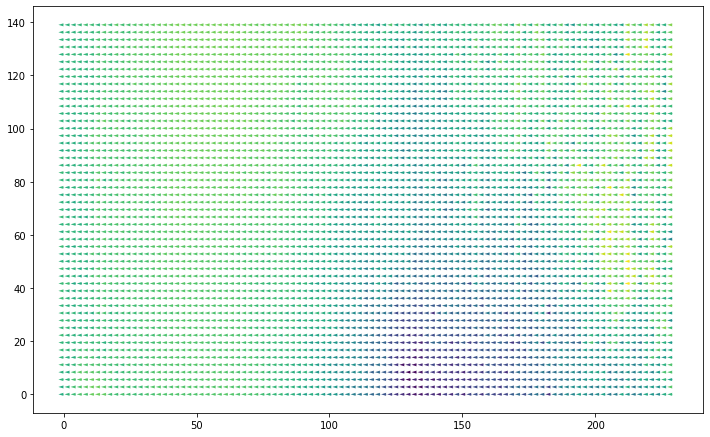

In [180]:
# Initialize mesh function for interior domains
domains = MeshFunction("size_t", mesh, mesh.topology().dim())
domains.set_all(0)
obstacle.mark(domains, 1)

# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
top.mark(boundaries, 2)
right.mark(boundaries, 3)
bottom.mark(boundaries, 4)

# Define input data
l0 = Constant(1.0)
l1 = Constant(0.01)
g_L = Constant(1.0)
g_R = Constant(-1.0)

# Define new measures associated with the interior domains and
# exterior boundaries
dx = Measure('dx', domain=mesh, subdomain_data=domains)
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# Define trial and test functions over function space
u = TrialFunction(V);
v = TestFunction(V);

# Define bilinear and linear form
a0 = inner(l0*grad(u), grad(v))*dx(0);
a1 = inner(l1*grad(u), grad(v))*dx(1);
a = a0 + a1;
L = g_L*v*ds(1) + g_R*v*ds(3);

# Solve problem
u = Function(V)
solve(a == L, u)
plt.figure(figsize=(12,10))
plot(u)
plt.figure(figsize=(12,10))
plot(grad(u))

## Variational Formulation

We will use Finite Elements to investigate heat flux through these domains. 

$$
\int_\Omega (\nabla \lambda \cdot \nabla u + \lambda\nabla^2 u)\cdot v\, dx = 0\\
\int_\Omega \lambda\cdot(\nabla u\ \cdot\nabla v)\,dx - \int_\Omega (\nabla \lambda \cdot \nabla u) \cdot v  = \lambda\int_{\partial\Omega} \nabla u\cdot v\,ds
$$

We will impose a flux of `1` on the vertical boundaries. That is we have

$$
\nabla u = g(x) = \left\{\begin{array}{rl}
1 & \text{on left/right boundary} \\
0 & \text{on top/bottom boundary}
\end{array}\right.
$$

In [170]:
# Define trial and test functions over function space
u = TrialFunction(V);
v = TestFunction(V);

# Define bilinear form
a1 = psi*inner(grad(u),grad(v))*dx;
a2 = inner(grad(psi),grad(u))*v*dx;
a = a1-a2;

# Define boundary function
g = Expression("(abs(x[0]) < DOLFIN_EPS || abs(x[0]-239.) < DOLFIN_EPS) ? 1 : 0", degree=2)
L = psi*g*v*ds 

In [135]:
# Compute solution
u = Function(V)
solve(a == L, u)

In [140]:
plot(g,mesh)

RuntimeError: Expecting a mesh as keyword argument

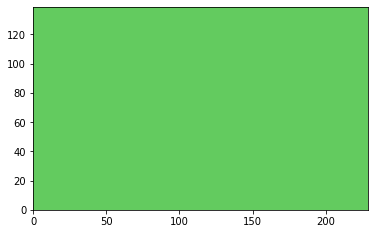

In [104]:
plot(psi)